In [3]:
import pandas as pd

%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

import os
import IPython.display


In [4]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.explain as explain
import pyAgrum.lib.bn_vs_bn as bnvsbn


# Learning the Structure of a Bayesian Network

## [Study 1] Discrete BNs - Tuberculosis BN 

### Load BN

In [5]:
bn = gum.loadBN("bns/asia.bif")
bn

(pyAgrum.BayesNet<double>@0x7ff69f03b200) BN{nodes: 8, arcs: 8, domainSize: 256, dim: 18, mem: 288o}

### Check Conditional Probability Tables

In [6]:
gnb.sideBySide( bn.cpt( "smoking" ), bn.cpt( "visit_to_Asia" ), bn.cpt( "lung_cancer" ), bn.cpt( "tuberculosis" ), bn.cpt( "bronchitis" ), bn.cpt( "tuberculos_or_cancer" ), bn.cpt( "dyspnoea" ), bn.cpt( "positive_XraY" ) )

### Check Marginals

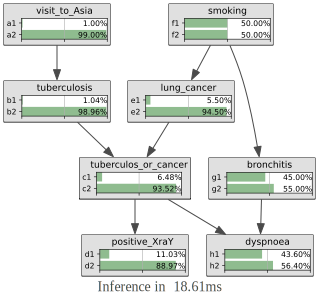

In [7]:
gnb.showInference(bn,evs={})

In [8]:
nb.showInference(bn,evs={"tuberculosis":"c1"})

OutOfBounds: [pyAgrum] Out of bound error: label 'c1' is unknown in tuberculosis:Labelized({b1|b2})

### Generating Samples from Bayesian Net (no missing data)

In [123]:
NUM_SAMPLES = 1000

log_likelihood = gum.generateSample( bn, NUM_SAMPLES, "generated_bns/sample_asia_bn.csv", show_progress = True,  with_labels=True, random_order=True )


generated_bns/sample_asia_bn.csv: 100%|████████████████████|

Log2-Likelihood : -3296.7114541874175


In [124]:
# loading generated samples
samples = pd.read_csv( "generated_bns/sample_asia_bn.csv")
samples

n = 10
samples.iloc[0:n, :]

,positive_XraY,tuberculosis,lung_cancer,dyspnoea,bronchitis,smoking,visit_to_Asia,tuberculos_or_cancer
0,d2,b2,e2,h1,g1,f2,a2,c2
1,d1,b2,e2,h2,g2,f2,a2,c2
2,d1,b2,e2,h2,g1,f1,a2,c2
3,d2,b2,e2,h1,g1,f1,a2,c2
4,d1,b2,e1,h2,g1,f1,a2,c1
...,...,...,...,...,...,...,...,...
995,d2,b2,e2,h1,g1,f1,a2,c2
996,d2,b2,e2,h1,g2,f2,a2,c2
997,d2,b2,e2,h2,g2,f2,a2,c2
998,d2,b2,e2,h1,g1,f1,a2,c2


### Structure Learning (Learning a Bayesian Network from Data)



https://pyagrum.readthedocs.io/en/1.7.1/BNLearning.html#pyAgrum.BNLearner.useMIIC

Learning methods:
- useMIIC() 
    - Multivariate Information based Inductive Causation (MIIC)
- useGreedyHillClimbing()
- useLocalSearchWithTabuList() 
    - implements a greedy search in which we allow applying at most N consecutive graph changes that decrease the score. To prevent infinite loops, when using local search, you should use a structural constraint that includes a tabu list of at least N elements.
- useK2() 
    - needs total ordering of the variables (https://github.com/danieleninni/bayesian-network-k2-algorithm)
- use3off2() 
    - https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-015-0856-x
- useEM()

Score methods:
- useScoreAIC()
- useScoreBD()
- useScoreBDeu()
- useScoreBIC()
- useScoreK2()
- useSoreLog2Likelihood()

Priors:
- useSmoothingPrior(weight=1)
- useDirichletPrior()
- useBDeuPrior()
- useAprioriSmoothing()
- useAprioriDirichlet()
- useAprioriBDeu()

Correction:
- useMDLCorrection()
- useNMLCorrection()

### Multivariate Information based Inductive Causation

In [125]:
ALGORITHM = "MIIC"
learner_miic = gum.BNLearner(samples)

# use prior
learner_miic.useSmoothingPrior()

# specify score function
learner_miic.useScoreLog2Likelihood() 

# specify learning algorithm
learner_miic.useMIIC()

# learn network
bn_miic = learner_miic.learnBN()

print(learner_miic)

gnb.sideBySide(bn,bn_miic,gnb.getBNDiff(bn,bn_miic),explain.getInformation(bn_miic),captions=["Original BN","Learned BN using " + ALGORITHM,"Graphical diff","information"])

Filename       : /var/folders/sh/yfwy9_gn2gjcw7xcsnv37y_w0000gp/T/tmp97ixofwf.csv
Size           : (1000,8)
Variables      : positive_XraY[2], tuberculosis[2], lung_cancer[2], dyspnoea[2], bronchitis[2], smoking[2], visit_to_Asia[2], tuberculos_or_cancer[2]
Induced types  : True
Missing values : False
Algorithm      : MIIC
Score          : Log2Likelihood
Correction     : MDL  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 1.000000



In [126]:
gnb.sideBySide( bn.cpt( "smoking" ), bn_miic.cpt( "visit_to_Asia" ), bn_miic.cpt( "lung_cancer" ), bn_miic.cpt( "tuberculosis" ), bn_miic.cpt( "bronchitis" ), bn_miic.cpt( "tuberculos_or_cancer" ), bn_miic.cpt( "dyspnoea" ), bn_miic.cpt( "positive_XraY" ) )

### Greedy Hill Climbing

In [127]:
ALGORITHM = "Greedy Hill Climbing"
learner_ghc = gum.BNLearner(samples)

# use prior
learner_ghc.useSmoothingPrior()

# specify score function
learner_ghc.useScoreLog2Likelihood() 

# specify learning algorithm
learner_ghc.useGreedyHillClimbing()

# add contextual knowledge
# learner_ghc.addMandatoryArc("visit_to_Asia","tuberculosis")

# learn network
bn_ghc = learner_ghc.learnBN()

print(learner_ghc)

gnb.sideBySide(bn,bn_ghc,gnb.getBNDiff(bn,bn_ghc),explain.getInformation(bn_ghc),captions=["Original BN","Learned BN using " + ALGORITHM,"Graphical diff","information"])


Filename       : /var/folders/sh/yfwy9_gn2gjcw7xcsnv37y_w0000gp/T/tmpenrfrxm1.csv
Size           : (1000,8)
Variables      : positive_XraY[2], tuberculosis[2], lung_cancer[2], dyspnoea[2], bronchitis[2], smoking[2], visit_to_Asia[2], tuberculos_or_cancer[2]
Induced types  : True
Missing values : False
Algorithm      : Greedy Hill Climbing
Score          : Log2Likelihood
Correction     : MDL  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 1.000000



In [128]:
gnb.sideBySide( bn_ghc.cpt( "smoking" ), bn_ghc.cpt( "visit_to_Asia" ), bn_ghc.cpt( "lung_cancer" ), bn_ghc.cpt( "tuberculosis" ), bn_ghc.cpt( "bronchitis" ), bn_ghc.cpt( "tuberculos_or_cancer" ), bn_ghc.cpt( "dyspnoea" ), bn_ghc.cpt( "positive_XraY" ) )

### Hybrid Approaches

In [129]:
ALGORITHM = "GHC + MIIC"
learner_hybrid = gum.BNLearner(samples)
learner_hybrid.useSmoothingPrior()

# specify score function
learner_hybrid.useScoreLog2Likelihood() 

# specify learning algorithm
learner_hybrid.useGreedyHillClimbing()

# learn network
bn_hybrid = learner_hybrid.learnBN()

print(learner_hybrid)

gnb.sideBySide(bn,bn_hybrid,gnb.getBNDiff(bn,bn_hybrid),explain.getInformation(bn_hybrid),captions=["Original BN","Learned BN using " + ALGORITHM,"Graphical diff","information"])



Filename       : /var/folders/sh/yfwy9_gn2gjcw7xcsnv37y_w0000gp/T/tmp2i9wpjqz.csv
Size           : (1000,8)
Variables      : positive_XraY[2], tuberculosis[2], lung_cancer[2], dyspnoea[2], bronchitis[2], smoking[2], visit_to_Asia[2], tuberculos_or_cancer[2]
Induced types  : True
Missing values : False
Algorithm      : Greedy Hill Climbing
Score          : Log2Likelihood
Correction     : MDL  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 1.000000



In [130]:
ALGORITHM = "GHC + MIIC"
learner_hybrid = gum.BNLearner(samples)
learner_hybrid.useSmoothingPrior()

# specify score function
learner_hybrid.useScoreLog2Likelihood() 

# specify learning algorithm
learner_hybrid.useEM(epsilon=0.0001)
learner_hybrid.setInitialDAG(bn_hybrid.dag())

# learn network
bn_hybrid = learner_hybrid.learnBN()

print(learner_hybrid)

gnb.sideBySide(bn,bn_hybrid,gnb.getBNDiff(bn,bn_hybrid),explain.getInformation(bn_hybrid),captions=["Original BN","Learned BN using " + ALGORITHM,"Graphical diff","information"])




Filename       : /var/folders/sh/yfwy9_gn2gjcw7xcsnv37y_w0000gp/T/tmpjo8ixoei.csv
Size           : (1000,8)
Variables      : positive_XraY[2], tuberculosis[2], lung_cancer[2], dyspnoea[2], bronchitis[2], smoking[2], visit_to_Asia[2], tuberculos_or_cancer[2]
Induced types  : True
Missing values : False
Algorithm      : Greedy Hill Climbing
Score          : Log2Likelihood
Correction     : MDL  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 1.000000
EM             : True
EM epsilon     : 0.000100  (But no missing values in this database)
Initial DAG    : True  (digraph {
     0;
     1;
     2;
     3;
     4;
     5;
     6;
     7;

     2 -> 7;
     4 -> 5;
     7 -> 3;
     1 -> 7;
     2 -> 5;
     3 -> 4;
     7 -> 0;
     2 -> 4;
}

)



## Impact of the size of the database for the learning


In [134]:
log_likelihood = gum.generateSample( bn, 500000, "generated_bns/sample_asia_bn_50000.csv", show_progress = True,  with_labels=True, random_order=True )

rows=3
sizes=[400,500,700,1000,2000,5000,
       10000,50000,75000,
       100000,150000,175000,
       200000,300000,500000]

def extract_asia(n):
    """
    extract n line from asia.csv to extract.csv
    """
    samples = pd.read_csv( "generated_bns/sample_asia_bn_50000.csv")
    return samples.iloc[0:n, :]

generated_bns/sample_asia_bn_50000.csv: 100%|██████████████|


Log2-Likelihood : -1616943.7028889107


(400,8)
(500,8)
(700,8)
(1000,8)
(2000,8)
(5000,8)
(10000,8)
(50000,8)
(75000,8)
(100000,8)
(150000,8)
(175000,8)
(200000,8)
(300000,8)
(500000,8)


3.348546147608129e-05


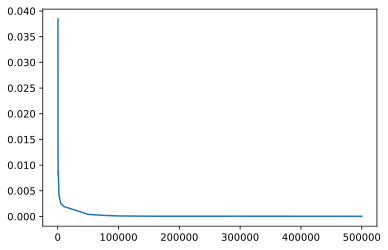

In [135]:
gnb.flow.clear()
nbr=0
l=[]
for i in sizes:
    samples_i = extract_asia(i)
    learner=gum.BNLearner(samples_i, bn) # using bn as template for variables
    learner.useGreedyHillClimbing()
    print(learner.state()["Size"][0])
    bn2=learner.learnBN()

    kl=gum.ExactBNdistance(bn,bn2)
    r=kl.compute()
    l.append(r['klPQ'])

    gnb.flow.add(gnb.getBNDiff(bn,bn2,size='3!'),f"size={i}")

gnb.flow.display()
plot(sizes,l)
print(l[-1])

(400,8)
(500,8)
(700,8)
(1000,8)
(2000,8)
(5000,8)
(10000,8)
(50000,8)
(75000,8)
(100000,8)
(150000,8)
(175000,8)
(200000,8)
(300000,8)
(500000,8)


2.919904314912635e-05


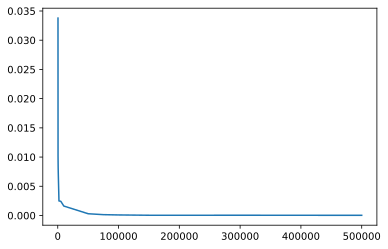

In [138]:
gnb.flow.clear()
nbr=0
l=[]
for i in sizes:
    samples_i = extract_asia(i)
    learner=gum.BNLearner(samples_i, bn) # using bn as template for variables
    learner.useMIIC()
    learner.addMandatoryArc("smoking","bronchitis")
    print(learner.state()["Size"][0])
    bn2=learner.learnBN()

    kl=gum.ExactBNdistance(bn,bn2)
    r=kl.compute()
    l.append(r['klPQ'])

    gnb.flow.add(gnb.getBNDiff(bn,bn2,size='3!'),f"size={i}")

gnb.flow.display()
plot(sizes,l)
print(l[-1])